In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.utils import shuffle


warnings.filterwarnings("ignore")
%matplotlib inline

/home/teknus/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Preprocessing

## Feature Engineering

In [2]:
file= open('bots.1k.csv', mode='r', encoding='utf-8', errors='ignore')
bots1k = pd.read_csv(file)
file= open('humans.1k.csv', mode='r', encoding='utf-8', errors='ignore')
humans1k = pd.read_csv(file)
bots1k['bot'] = 1
humans1k['bot'] = 0
print(len(bots1k),len(humans1k))
print(len(bots1k) + len(humans1k))
humasn1k = shuffle(humans1k)
humans1k = humans1k.iloc[0:len(bots1k)]
print(len(bots1k),len(humans1k))
print(len(bots1k) + len(humans1k))

498 791
1289
498 498
996


In [2]:
file= open('bots.100k.csv', mode='r', encoding='utf-8', errors='ignore')
bots100k = pd.read_csv(file)
file= open('humans.100k.csv', mode='r', encoding='utf-8', errors='ignore')
humans100k = pd.read_csv(file)
bots100k['bot'] = 1
humans100k['bot'] = 0
print(len(bots100k),len(humans100k))
print(len(bots100k) + len(humans100k))
humasn100k = shuffle(humans100k)
humans100k = humans100k.iloc[0:len(bots100k)]
print(len(bots100k),len(humans100k))
print(len(bots100k) + len(humans100k))


704 734
1438
704 704
1408


In [4]:
file= open('bots.1M.csv', mode='r', encoding='utf-8', errors='ignore')
bots1M = pd.read_csv(file)
file= open('humans.1M.csv', mode='r', encoding='utf-8', errors='ignore')
humans1M = pd.read_csv(file)
bots1M['bot'] = 1
humans1M['bot'] = 0
print(len(bots1M),len(humans1M))
print(len(bots1M) + len(humans1M))
humasn1M = shuffle(humans1M)
humans1M = humans1M.iloc[0:len(bots1M)]
print(len(bots1M),len(humans1M))
print(len(bots1M) + len(humans1M))

265 389
654
265 265
530


In [5]:
file= open('bots.10M.csv', mode='r', encoding='utf-8', errors='ignore')
bots10M = pd.read_csv(file)
file= open('humans.10M.csv', mode='r', encoding='utf-8', errors='ignore')
humans10M = pd.read_csv(file)
bots10M['bot'] = 1
humans10M['bot'] = 0
print(len(bots10M),len(humans10M))
print(len(bots10M) + len(humans10M))
humasn10M = shuffle(humans10M)
humans10M = humans10M.iloc[0:len(bots10M)]
print(len(bots10M),len(humans10M))
print(len(bots10M) + len(humans10M))

25 25
50
25 25
50


In [7]:
ratio = 0.70
humans_train1k = humans1k.sample(frac=ratio,random_state=200)
humans_test1k = humans1k.drop(humans_train1k.index)
humans_train100k = humans100k.sample(frac=ratio,random_state=200)
humans_test100k = humans100k.drop(humans_train100k.index)
humans_train1M = humans1M.sample(frac=ratio,random_state=200)
humans_test1M = humans1M.drop(humans_train1M.index)
humans_train10M = humans10M.sample(frac=ratio,random_state=200)
humans_test10M = humans10M.drop(humans_train10M.index)

humans_train = pd.concat([humans_train1k,humans_train100k,humans_train1M,humans_train10M],ignore_index=True)
humans_test = pd.concat([humans_test1k,humans_test100k,humans_test1M,humans_test10M],ignore_index=True)

bots_train1k = bots1k.sample(frac=ratio,random_state=200)
bots_test1k = bots1k.drop(bots_train1k.index)
bots_train100k = bots100k.sample(frac=ratio,random_state=200)
bots_test100k = bots100k.drop(bots_train100k.index)
bots_train1M = bots1M.sample(frac=ratio,random_state=200)
bots_test1M = bots1M.drop(bots_train1M.index)
bots_train10M = bots10M.sample(frac=ratio,random_state=200)
bots_test10M = bots10M.drop(bots_train10M.index)

bots_train = pd.concat([bots_train1k,bots_train100k,bots_train1M,bots_train10M],ignore_index=True)
bots_test = pd.concat([bots_test1k,bots_test100k,bots_test1M,bots_test10M],ignore_index=True)
print(len(bots_train) + len(humans_train) + len(bots_test) +len(humans_test))

2984


In [8]:
bots_train = bots_train.drop(['source_identity','screen_name','cdn_content_in_kb'], axis=1)
humans_train = humans_train.drop(['source_identity','screen_name','cdn_content_in_kb','sources_count'], axis=1)
bots_test = bots_test.drop(['source_identity','screen_name','cdn_content_in_kb'], axis=1)
humans_test = humans_test.drop(['source_identity','screen_name','cdn_content_in_kb','sources_count'], axis=1)

## Feature Extraction

In [9]:
features = ['user_tweeted',
            'user_retweeted',
            'user_favourited',
            'user_replied',
            'likes_per_tweet',
            'retweets_per_tweet',
            'lists_per_user',
            'follower_friend_ratio',
            'tweet_frequency',
            'favourite_tweet_ratio',
            'age_of_account_in_days',
            'urls_count']

from itertools import combinations

comb = []

for item in filter(lambda i:len(i) >= 2, [list(map(list, combinations(features, i))) for i in range(len(features) + 1)]):
  for i in item:
    if len(i) >= 3 and len(i) < len(features):
      if i not in comb:
        comb.append(i)

In [10]:
comb.sort(key=lambda i: len(i))
len(features)

12

### Merge dataset to train

In [11]:
train = pd.concat([bots_train,humans_train],ignore_index=True)
test = pd.concat([bots_test,humans_test],ignore_index=True)
concant = pd.concat([train,test],ignore_index=True)
X = concant[features]
y =concant['bot']

### Plain data metrics

In [12]:
for i in range(0,3):
  db = KMeans(n_clusters=2,  max_iter = 600).fit(X[features])

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print("Kmeans silhouette of bots {:f}".format(metrics.silhouette_score(X, labels)))
  print("Kmeans homogeneity of bots {:f}".format(metrics.homogeneity_score(y, labels)))
  print("Kmeans density of bots {:f}".format(metrics.silhouette_score(X, labels)))


Kmeans silhouette of bots 0.997556
Kmeans homogeneity of bots 0.000335
Kmeans density of bots 0.997556
Kmeans silhouette of bots 0.997556
Kmeans homogeneity of bots 0.000335
Kmeans density of bots 0.997556
Kmeans silhouette of bots 0.997556
Kmeans homogeneity of bots 0.000335
Kmeans density of bots 0.997556


### Noramlization

In [13]:
from sklearn.preprocessing import MinMaxScaler

X_train = MinMaxScaler().fit_transform(train[features])
y_train = train['bot']
X_test = MinMaxScaler().fit_transform(test[features])
y_test = test['bot']
X_norm = MinMaxScaler().fit_transform(X[features])

### Plain Normalized data metrics

In [14]:
for i in range(0,3):
  db = KMeans(n_clusters=2).fit(X_norm)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print("Kmeans silhouette of bots {:f}".format(metrics.silhouette_score(X_norm, labels)))
  print("Kmeans homogeneity of bots {:f}".format(metrics.homogeneity_score(y, labels)))

Kmeans silhouette of bots 0.545258
Kmeans homogeneity of bots 0.000778
Kmeans silhouette of bots 0.545258
Kmeans homogeneity of bots 0.000778
Kmeans silhouette of bots 0.545258
Kmeans homogeneity of bots 0.000778


### Brute Force feature selection

In [15]:
from sys import stdout

homogeneity = []
i = len(comb)
for order in comb:
  stdout.write("\r%d" % i)
  stdout.flush()
  i -= 1
  X_bt = X[order]
  y_bt = y

  db = KMeans(n_clusters=2,max_iter = 600).fit(X_bt)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_
  
  homogeneity.append([order,metrics.homogeneity_score(y_bt, labels)])

1000

In [16]:
homogeneity.sort(key=lambda i: -1 * i[1])
X_brut = X[homogeneity[0][0]]

X_train_brut, X_test_brut= MinMaxScaler().fit_transform(train[homogeneity[0][0]]),MinMaxScaler().fit_transform(test[homogeneity[0][0]])
X_train_brut

array([[0.03951368, 0.01762558, 0.        ],
       [0.0006079 , 0.00616865, 0.        ],
       [0.00121581, 0.01176728, 0.        ],
       ...,
       [0.02370821, 0.00435457, 0.04439458],
       [0.08510638, 0.0056951 , 0.00180999],
       [0.0006079 , 0.00421731, 0.01332785]])

### Feature Validation by Homogenity on clusters K-means using brutforced features

In [17]:
for i in range(0,3):
  db = KMeans(n_clusters=2).fit(X_brut)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  labels = db.labels_

  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print("Kmeans silhouette of bots {:f}".format(metrics.silhouette_score(X_brut, labels)))
  print("Kmeans homogeneity of bots {:f}".format(metrics.homogeneity_score(y, labels)))

Kmeans silhouette of bots 0.933815
Kmeans homogeneity of bots 0.007751
Kmeans silhouette of bots 0.933815
Kmeans homogeneity of bots 0.007751
Kmeans silhouette of bots 0.933815
Kmeans homogeneity of bots 0.007751


#### Metrics

In [18]:
def show_metrics_test(y_test, y_pred_test):
    print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
    print("F1 score test {}".format(f1_score(y_test,y_pred_test)))
    print("Precision score test {}".format(precision_score(y_test,y_pred_test)))
    print("Recall score test {}".format(recall_score(y_test,y_pred_test)))
    print("Confusion Matrix score test {}".format(confusion_matrix(y_test,y_pred_test)))

def show_metrics_train(y_train,y_pred_train):
    print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
    print("F1 score train {}".format(f1_score(y_train,y_pred_train)))
    print("Precision score train {}".format(precision_score(y_train,y_pred_train)))
    print("Recall score train {}".format(recall_score(y_train,y_pred_train)))
    print("Confusion Matrix score train {}".format(confusion_matrix(y_train,y_pred_train)))

def show_curve(clf,X_train, y_train, X_test, y_test):
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid", {'axes.grid' : False})

    scores_train = clf.predict_proba(X_train)
    scores_test = clf.predict_proba(X_test)

    y_scores_train = []
    y_scores_test = []
    for i in range(len(scores_train)):
        y_scores_train.append(scores_train[i][1])

    for i in range(len(scores_test)):
        y_scores_test.append(scores_test[i][1])

    fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
    fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

    plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %2f' %auc(fpr_dt_train, tpr_dt_train))
    plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %2f' %auc(fpr_dt_test, tpr_dt_test))
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc='lower right')

## Models

In [19]:
def runner(clf,negative=True,cv=10):  
  print("Normalized")
  x = X_norm
  scores = cross_val_score(clf,x , y, cv=cv,scoring='accuracy')
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='f1')
  print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='precision')
  print("precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='recall')
  print("recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  print("BrutForce")
  x = X_brut
  scores = cross_val_score(clf,x , y, cv=cv,scoring='accuracy')
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='f1')
  print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='precision')
  print("precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  scores = cross_val_score(clf, x, y, cv=cv,scoring='recall')
  print("recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  if negative:
    print("PCA")
    x = X_pca
    scores = cross_val_score(clf,x , y, cv=cv,scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='f1')
    print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='precision')
    print("precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='recall')
    print("recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("LDA")
    x = X_lda
    scores = cross_val_score(clf,x , y, cv=cv,scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='f1')
    print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='precision')
    print("precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, x, y, cv=cv,scoring='recall')
    print("recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
def split_runner(clf,X_train, y_train, X_test, y_test,roc=True):
  clf = clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)
  show_metrics_train(y_train, y_pred_train)
  show_metrics_test(y_test, y_pred_test)
  if roc:
    show_curve(clf,X_train, y_train, X_test, y_test)
  return clf

#### training

In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [2,10,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,8,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [2,10,100,200]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1)
CV_rfc.fit(X_train_brut, y_train)
CV_rfc.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 785 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 1135 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1585 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.6min finished


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'n_estimators': 200}

Trainig Accuracy: 0.71558
F1 score train 0.7032418952618454
Precision score train 0.735140771637122
Recall score train 0.6739961759082218
Confusion Matrix score train [[792 254]
 [341 705]]
Test Accuracy: 0.70852
F1 score test 0.6551724137931034
Precision score test 0.801948051948052
Recall score test 0.5538116591928252
Confusion Matrix score test [[385  61]
 [199 247]]


['random_forest_classifier.pkl']

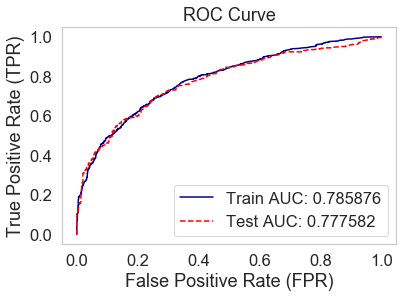

In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion= 'gini',
 max_depth= 4,
 max_features= 'auto',
 min_samples_leaf= 10,
 n_estimators= 200)
clf = split_runner(clf,X_train_brut, y_train, X_test_brut, y_test)
filename = 'random_forest_classifier.pkl'
joblib.dump(clf, filename)

In [33]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [3,5,7,9,11,13,15,21,23,47],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan','minkowski'],
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5,verbose=1,n_jobs=-1)
CV_clf.fit(X_train_brut, y_train)
CV_clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    9.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.8s finished


{'metric': 'euclidean', 'n_neighbors': 47, 'weights': 'uniform'}

Trainig Accuracy: 0.70363
F1 score train 0.6918489065606362
Precision score train 0.7204968944099379
Recall score train 0.6653919694072657
Confusion Matrix score train [[776 270]
 [350 696]]
Test Accuracy: 0.70404
F1 score test 0.6535433070866141
Precision score test 0.7879746835443038
Recall score test 0.5582959641255605
Confusion Matrix score test [[379  67]
 [197 249]]


['knn_classifier.pkl']

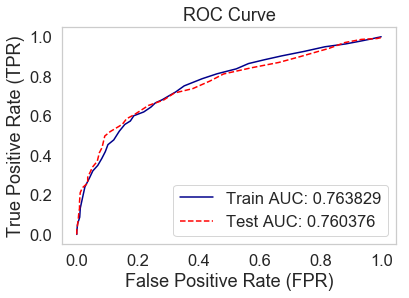

In [21]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(metric = 'euclidean', n_neighbors= 47, weights= 'uniform')

clf = split_runner(clf,X_train_brut, y_train, X_test_brut, y_test)
filename = 'knn_classifier.pkl'
joblib.dump(clf, filename)

## Vote

Trainig Accuracy: 0.70698
F1 score train 0.6924234821876568
Precision score train 0.7286166842661035
Recall score train 0.6596558317399618
Confusion Matrix score train [[789 257]
 [356 690]]
Test Accuracy: 0.71076
F1 score test 0.6596306068601583
Precision score test 0.8012820512820513
Recall score test 0.5605381165919282
Confusion Matrix score test [[384  62]
 [196 250]]


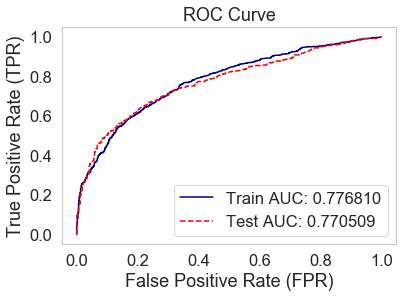

In [22]:
rf = joblib.load("random_forest_classifier.pkl")
knn = joblib.load("knn_classifier.pkl")

from sklearn.ensemble import VotingClassifier
est = [('knn', knn),('rf',rf)]
clf = VotingClassifier(estimators=est,
                        voting='soft',weights= [0.57,0.43])

a = split_runner(clf,X_train_brut, y_train, X_test_brut, y_test)

## Train Full feautres

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [2,10,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,8,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf': [2,10,100,200]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1,scoring="f1")
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  5.0min finished


{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 100}

Trainig Accuracy: 0.91922
F1 score train 0.91646070192783
Precision score train 0.9488229273285568
Recall score train 0.8862332695984704
Confusion Matrix score train [[996  50]
 [119 927]]
Test Accuracy: 0.71525
F1 score test 0.742914979757085
Precision score test 0.6771217712177122
Recall score test 0.8228699551569507
Confusion Matrix score test [[271 175]
 [ 79 367]]


['random_forest_classifier_full.pkl']

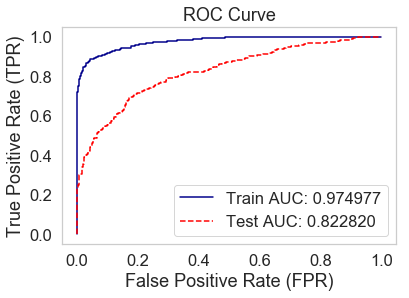

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion= 'entropy',
 max_depth= 10,
 max_features= 'auto',
 min_samples_leaf= 2,
 n_estimators= 100)
clf = split_runner(clf,X_train, y_train, X_test, y_test)
filename = 'random_forest_classifier_full.pkl'
joblib.dump(clf, filename)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [3,5,7,9,11,13,15,21,23,47],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan','minkowski'],
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5,verbose=1,n_jobs=-1)
CV_clf.fit(X_train, y_train)
CV_clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.9s finished


{'metric': 'manhattan', 'n_neighbors': 47, 'weights': 'distance'}

Trainig Accuracy: 1.00000
F1 score train 1.0
Precision score train 1.0
Recall score train 1.0
Confusion Matrix score train [[1046    0]
 [   0 1046]]
Test Accuracy: 0.66031
F1 score test 0.5888738127544099
Precision score test 0.7457044673539519
Recall score test 0.48654708520179374
Confusion Matrix score test [[372  74]
 [229 217]]


['knn_classifier_full.pkl']

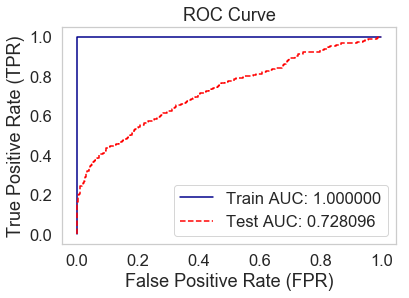

In [26]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(metric = 'manhattan', n_neighbors= 47, weights= 'distance')

clf = split_runner(clf,X_train, y_train, X_test, y_test)
filename = 'knn_classifier_full.pkl'
joblib.dump(clf, filename)

Trainig Accuracy: 1.00000
F1 score train 1.0
Precision score train 1.0
Recall score train 1.0
Confusion Matrix score train [[1046    0]
 [   0 1046]]
Test Accuracy: 0.73991
F1 score test 0.727699530516432
Precision score test 0.7635467980295566
Recall score test 0.695067264573991
Confusion Matrix score test [[350  96]
 [136 310]]


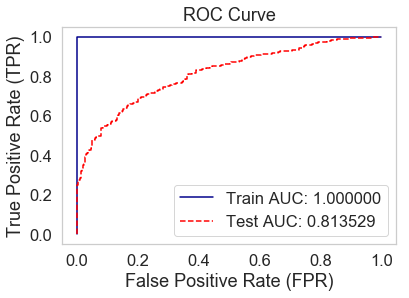

In [27]:
rf = joblib.load("random_forest_classifier_full.pkl")
knn = joblib.load("knn_classifier_full.pkl")

from sklearn.ensemble import VotingClassifier
est = [('knn', knn),('rf',rf)]
clf = VotingClassifier(estimators=est,
                        voting='soft',weights= [0.57,0.43])

clf = split_runner(clf,X_train, y_train, X_test, y_test)